In [4]:
%matplotlib inline
import numpy as np
import pylab as pl
from glob import glob
import os
from astropy.io import fits
from astropy import visualization
from astropy.visualization import simple_norm
pl.rcParams['image.origin'] = 'lower'
pl.style.use('dark_background')

In [5]:
biases = glob('darkOnly_40ms*.FIT')
darks_40ms_filelist = glob('darkOnly_40ms*.FIT')
darks_100ms_filelist = glob('darkOnly_40ms*.FIT')
clear_flat = glob('twilight_Clear*.FIT')
B_flat = glob('twilight_B*.FIT')
V_flat = glob('twilight_V*.FIT')
I_flat = glob('twilight_I*.FIT')

# Biases and Readnoise

In [6]:
bias_timestream = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in biases]
mean_bias = np.mean(bias_timestream, axis=0)
stddev_bias = np.std(bias_timestream, axis=0)
readnoise = np.mean(stddev_bias)
del bias_timestream

In [7]:
mean_bias_noise = readnoise/np.sqrt(len(biases))
mean_bias_noise

4.9151353755340494

# Flats

In [8]:
#Clear, B , V , I
flat = [clear_flat, B_flat, V_flat, I_flat]
flat_timestream = []
mean_flat = []
bias_subtracted_flat = []

for i in range(4):
    flat_timestream.append([fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in flat[i]])
    mean_flat.append(np.mean(flat_timestream[i], axis=0))
    bias_subtracted_flat.append(mean_flat[i] - mean_bias)

del flat_timestream
print(clear_flat)

['twilight_Clear002.FIT', 'twilight_Clear003.FIT', 'twilight_Clear001.FIT']


# Flat Uncertainty

In [9]:
gain = fits.getheader('twilight_Clear001.FIT')['EGAIN']
flat_poisson_uncertainty = []
flat_singleframe_uncertainty = []
flat_total_uncertainty = []
normalized_mean_flat = []

for i in range(4):
    flat_poisson_uncertainty.append((bias_subtracted_flat[i])**0.5)
    flat_singleframe_uncertainty.append((flat_poisson_uncertainty[i]**2 + readnoise**2)**0.5)
    flat_total_uncertainty.append(((flat_singleframe_uncertainty[i]/np.sqrt(len(flat[i])))**2 + mean_bias_noise**2)**0.5)
    mean_of_flat = np.mean(bias_subtracted_flat[i])
    normalized_mean_flat.append(bias_subtracted_flat[i] / mean_of_flat)


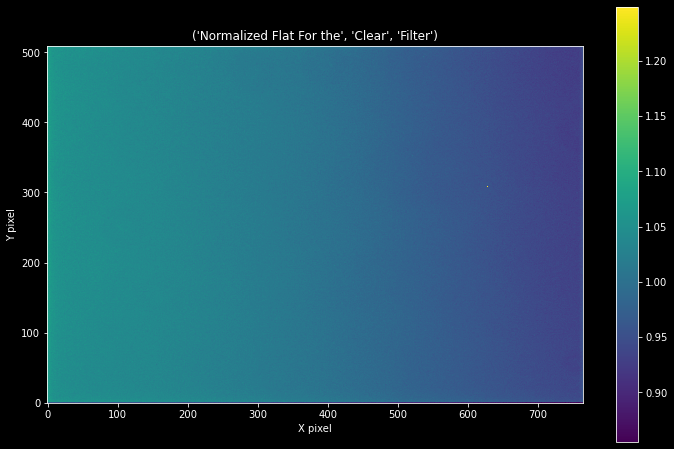

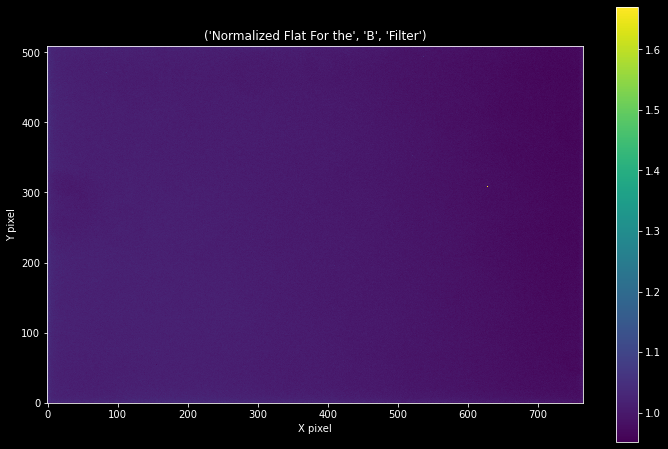

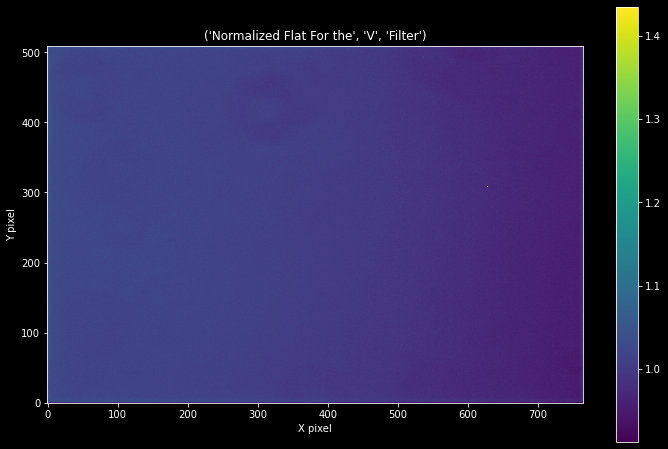

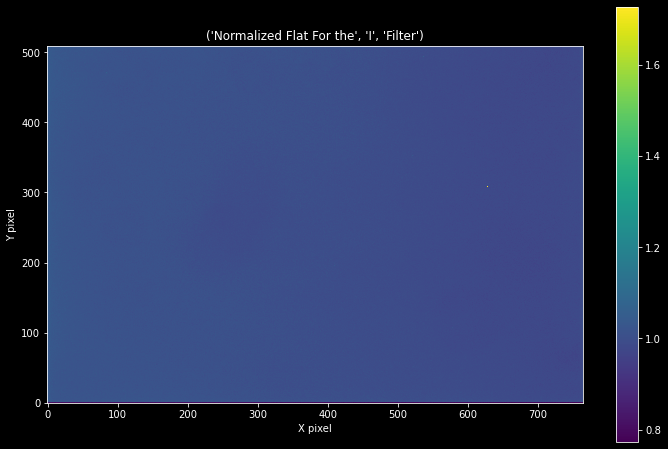

In [10]:
names = ["Clear", "B", "V", "I"]
for i in range(4):
    temp = 'Normalized Flat For the', names[i], 'Filter'
    pl.figure(figsize=(12,8))
    _=pl.imshow(normalized_mean_flat[i], origin='lower', interpolation='none')
    _=pl.colorbar()
    _=pl.title(temp)
    _=pl.xlabel("X pixel")
    _=pl.ylabel("Y pixel")

# Normalized Flat Uncertainty

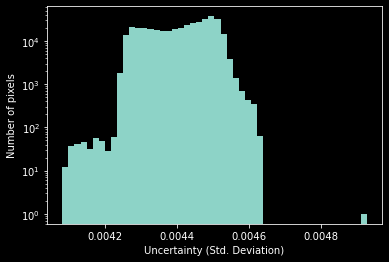

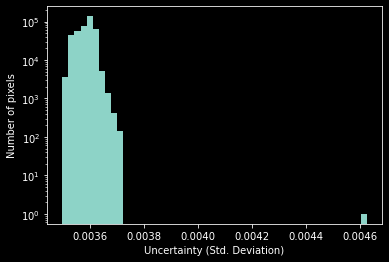

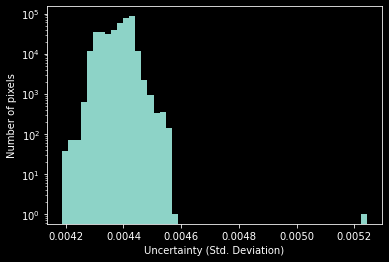

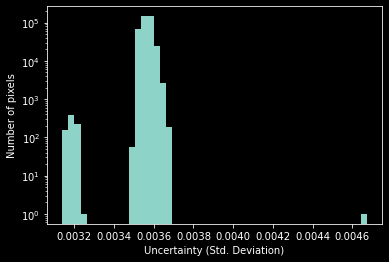

In [11]:
normalized_flat_uncertainty = []
for i in range(4):
    pl.figure()
    normalized_flat_uncertainty.append(flat_total_uncertainty[i] / mean_of_flat)
    pl.xlabel("Uncertainty (Std. Deviation)")
    pl.ylabel("Number of pixels")
    _=pl.hist(normalized_flat_uncertainty[i].ravel(), bins=50, log=True)


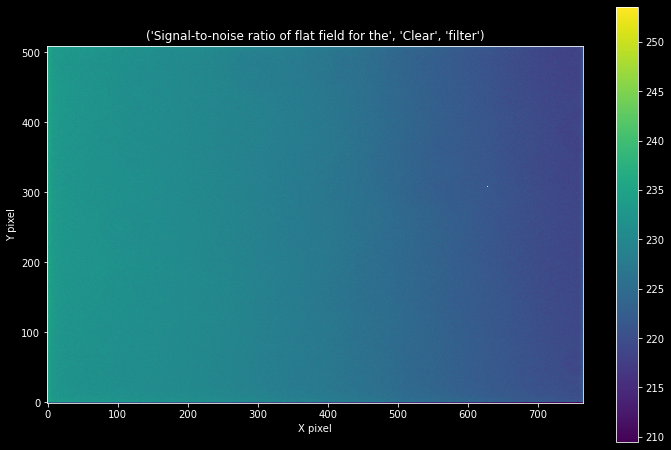

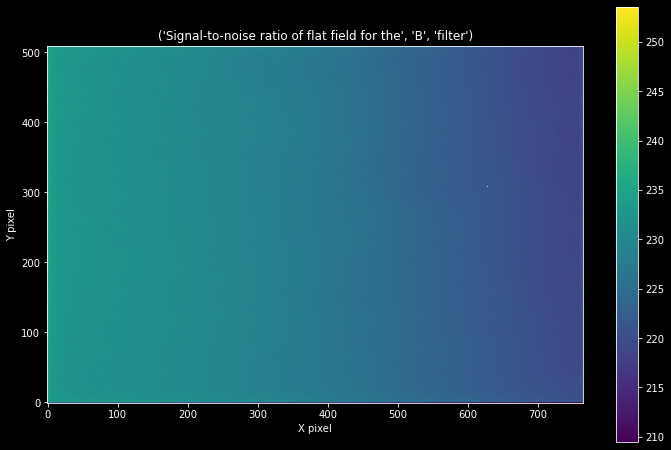

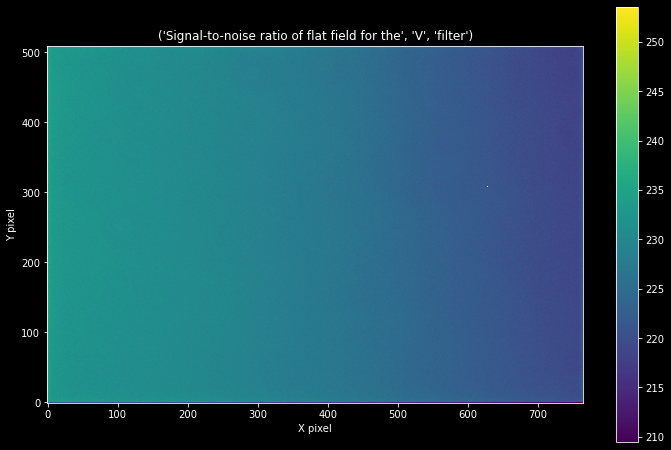

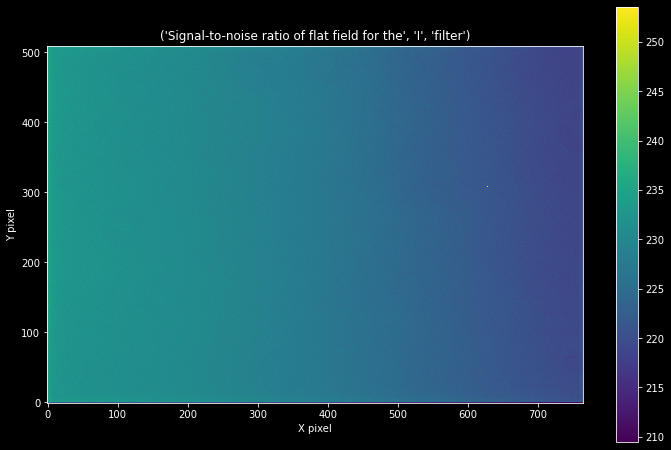

In [12]:
for i in range(4):
    temp = "Signal-to-noise ratio of flat field for the", names[i], "filter"
    pl.figure(figsize=(12,8))
    pl.imshow(normalized_mean_flat[0]/normalized_flat_uncertainty[0], origin='lower', interpolation='none')
    pl.title(temp)
    pl.colorbar()
    _=pl.xlabel("X pixel")
    _=pl.ylabel("Y pixel")

In [13]:
darks_40ms = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in darks_40ms_filelist]
average_40ms_dark = np.mean(darks_40ms, axis=0)
stddev_40ms_dark = np.std(darks_40ms, axis=0)
del darks_40ms

darks_100ms = [fits.getdata(x)*fits.getheader(x)['EGAIN'] for x in darks_100ms_filelist]
average_100ms_dark = np.mean(darks_100ms, axis=0)
stddev_100ms_dark = np.std(darks_100ms, axis=0)
del darks_100ms

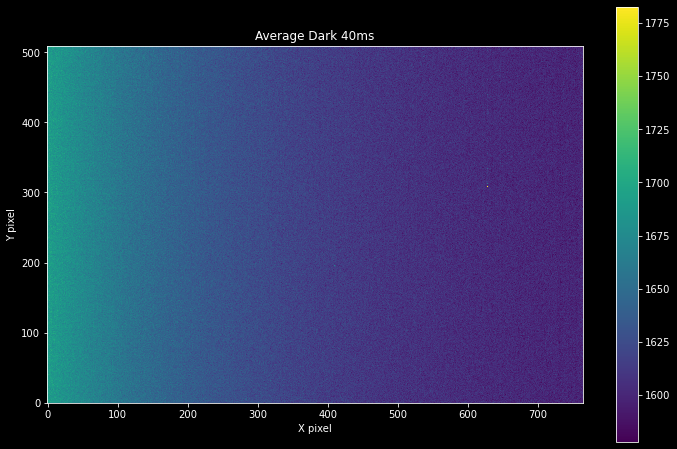

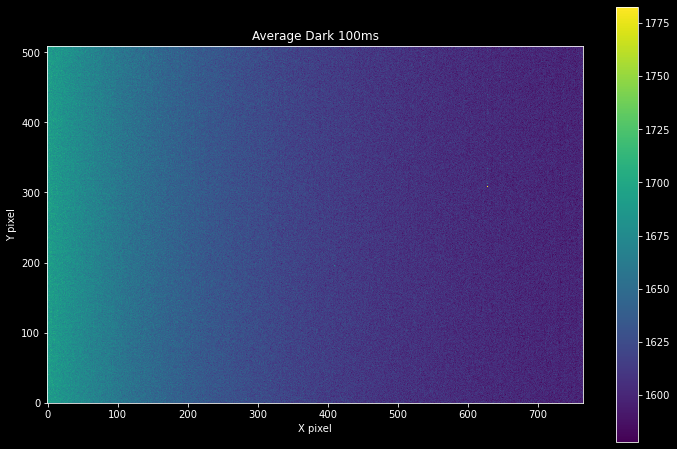

In [14]:
pl.figure(figsize=(12,8))
pl.imshow(average_40ms_dark, origin='lower', interpolation='none', vmax=1150*gain)
pl.colorbar()
_=pl.title("Average Dark 40ms")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

uncertainty_on_40ms_mean_dark = stddev_40ms_dark / np.sqrt(len(darks_40ms_filelist))

pl.figure(figsize=(12,8))
pl.imshow(average_100ms_dark, origin='lower', interpolation='none', vmax=1150*gain)
pl.colorbar()
_=pl.title("Average Dark 100ms")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

uncertainty_on_100ms_mean_dark = stddev_100ms_dark / np.sqrt(len(darks_100ms_filelist))

# Science Images

## Saturn

Saturn Alignment:

In [15]:
SaturnFilelist = ['Saturn_B_40ms002.FIT', 'Saturn_B_40ms003.FIT',
                 'Saturn_V_40ms001.FIT', 'Saturn_V_40ms002.FIT', 'Saturn_V_40ms003.FIT',
                 'Saturn_I_40ms001.FIT', 'Saturn_I_40ms002.FIT', 'Saturn_I_40ms003.FIT']

SaturnCenters_X = [409.3, 409.0, 409.0, 407.0, 410.0, 407.5, 409.0, 408.0]
SaturnCenters_Y = [217.7, 218.0, 213.6, 212.3, 214.0, 213.4, 214.3, 213.0] 

#Making 'Saturn_B_40ms001.FIT' the reference frame.
refx, refy = 408.6, 217.7 
Saturn_shift = [fits.getdata('Saturn_B_40ms001.FIT')*fits.getheader('Saturn_B_40ms001.FIT')[ 'EGAIN']]

for i in range(len(SaturnFilelist)):
    im = fits.getdata(SaturnFilelist[i])*fits.getheader(SaturnFilelist[i])[ 'EGAIN']
    dx = refx - SaturnCenters_X[i]
    dy = refy - SaturnCenters_Y[i]
    dx, dy = round(dx), round(dy)    
    im_shift = np.roll(im, dy, axis=0)
    im_shift = np.roll(im_shift, dx, axis=1)
    Saturn_shift.append(im_shift)
    #Saving the shifted images
    header = fits.getheader(SaturnFilelist[i])
    fh = fits.PrimaryHDU(data=im_shift, header=header) 
    fh.writeto('shifted_' + SaturnFilelist[i], overwrite=True)

header = fits.getheader('Saturn_B_40ms001.FIT')
fh = fits.PrimaryHDU(data=Saturn_shift[0], header=header) 
fh.writeto('shifted_' + 'Saturn_B_40ms001.FIT', overwrite=True)

Image Processing:

<ipython-input-16-7697d3812dcc>:14: RuntimeWarning: divide by zero encountered in true_divide
  saturn_darksub_flattened_uncertainty.append(((saturn_darksub_uncertainty[i]**2 / saturn_darksub[i]**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[num]**2) * saturn_darksub_flattened[i]**2)**0.5)
<ipython-input-16-7697d3812dcc>:14: RuntimeWarning: invalid value encountered in multiply
  saturn_darksub_flattened_uncertainty.append(((saturn_darksub_uncertainty[i]**2 / saturn_darksub[i]**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[num]**2) * saturn_darksub_flattened[i]**2)**0.5)
<ipython-input-16-7697d3812dcc>:12: RuntimeWarning: invalid value encountered in sqrt
  saturn_darksub_uncertainty.append((saturn_darksub[i] + readnoise**2 + uncertainty_on_40ms_mean_dark**2)**0.5)


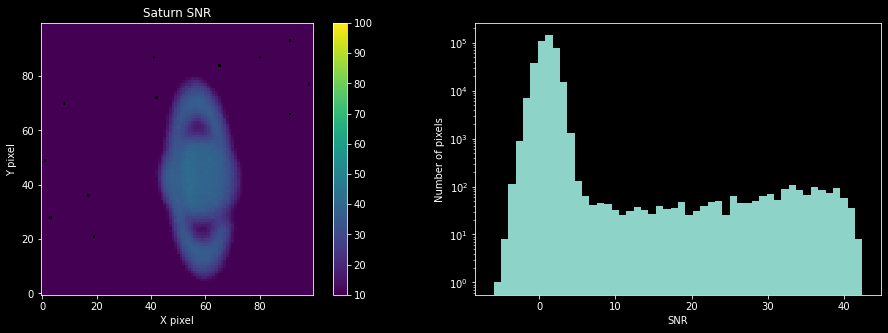

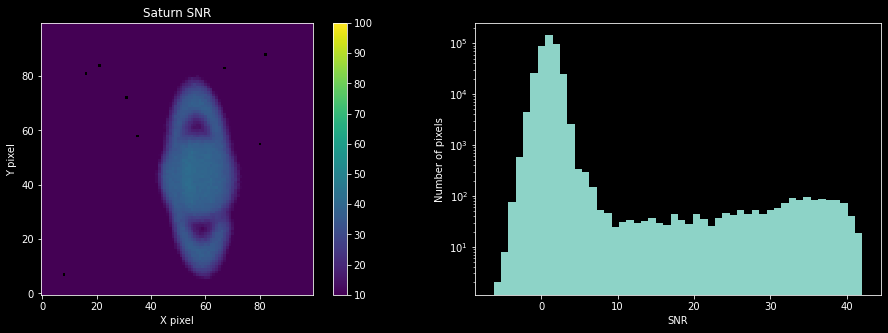

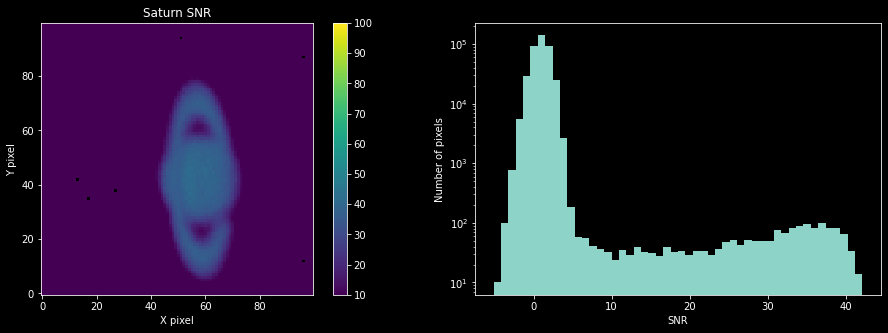

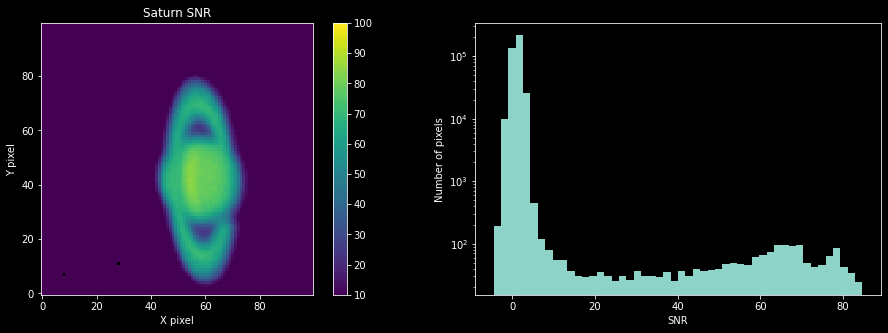

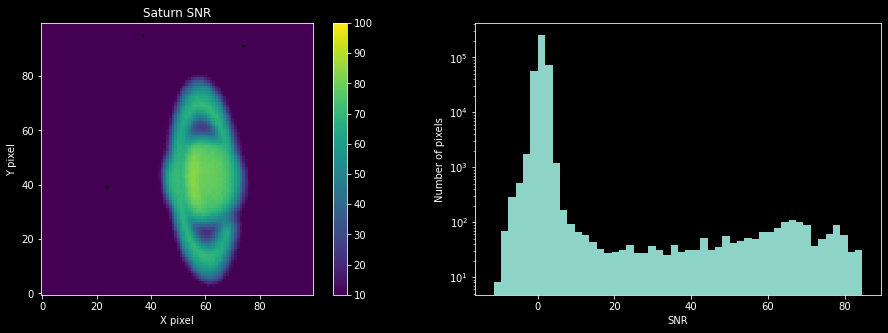

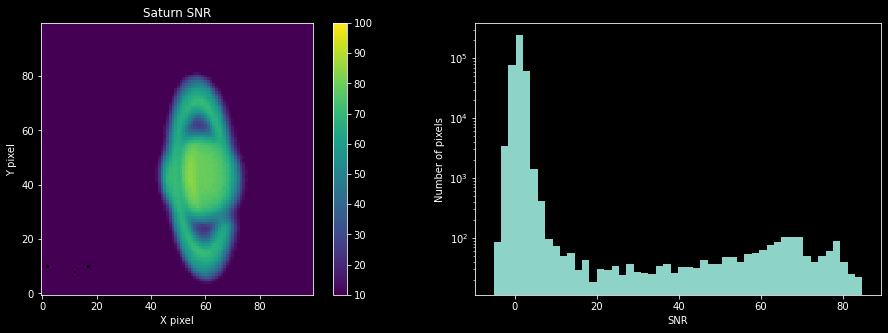

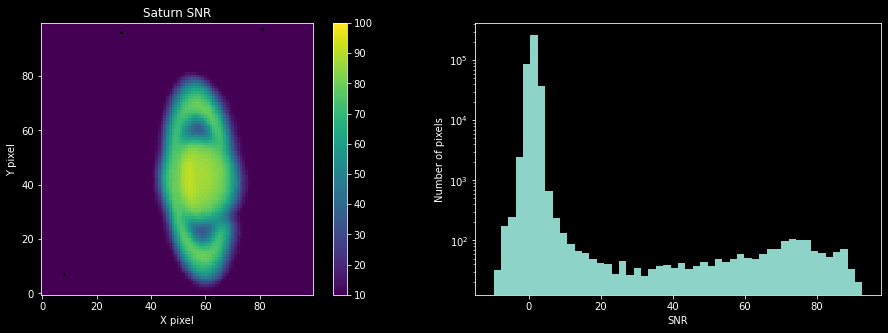

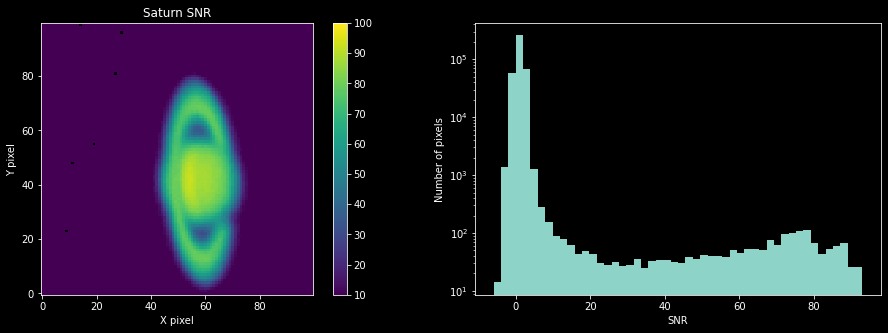

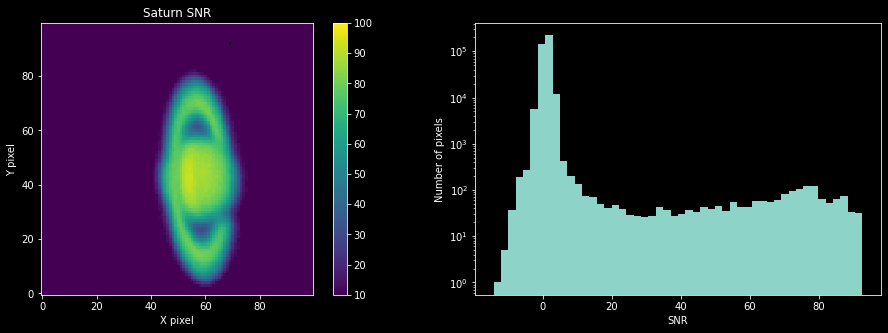

In [16]:
saturn_darksub = []
saturn_darksub_uncertainty = []
saturn_darksub_flattened = []
saturn_darksub_flattened_uncertainty = []
num = 0

for i in range(len(Saturn_shift)):
    if(i%3 == 0):
        num = num + 1
        #changes the flat filter
    saturn_darksub.append(Saturn_shift[i] - average_40ms_dark)
    saturn_darksub_uncertainty.append((saturn_darksub[i] + readnoise**2 + uncertainty_on_40ms_mean_dark**2)**0.5)
    saturn_darksub_flattened.append( saturn_darksub[i] / normalized_mean_flat[num])
    saturn_darksub_flattened_uncertainty.append(((saturn_darksub_uncertainty[i]**2 / saturn_darksub[i]**2 +normalized_flat_uncertainty[0]**2 / normalized_mean_flat[num]**2) * saturn_darksub_flattened[i]**2)**0.5)  
    SNR = saturn_darksub_flattened[i] / saturn_darksub_flattened_uncertainty[i]
    pl.figure(figsize=(16,5))
    #SNR Images:
    image = pl.subplot(1,2,1).imshow(SNR[175:275,350:450], origin='lower', interpolation='none', vmin=10, vmax=100)
    _=pl.title("Saturn SNR")
    _=pl.xlabel("X pixel")
    _=pl.ylabel("Y pixel")
    pl.colorbar(image)
    #Histogram:
    _ = pl.subplot(1,2,2).hist(SNR.ravel(), bins=50, log=True)
    _ = pl.xlabel("SNR")
    _ = pl.ylabel("Number of pixels")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


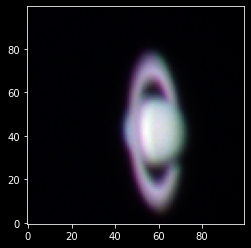

In [17]:
file_list_sat_shift_B = glob('shifted_Saturn_B*FIT')
file_list_sat_shift_V = glob('shifted_Saturn_V*FIT')
file_list_sat_shift_I = glob('shifted_Saturn_I*FIT')


timeseries_sat_B = np.array([fits.getdata(fn) for fn in file_list_sat_shift_B])
timeseries_sat_V = np.array([fits.getdata(fn) for fn in file_list_sat_shift_V])
timeseries_sat_I = np.array([fits.getdata(fn) for fn in file_list_sat_shift_I])

Bband_sat_median = np.median(timeseries_sat_B, axis = 0)
Vband_sat_median = np.median(timeseries_sat_V, axis = 0)
Iband_sat_median = np.median(timeseries_sat_I, axis = 0)

bslc = slice(175,275), slice(350,450)
vslc = slice(175,275), slice(350,450)
Islc = slice(175,275), slice(350,450)

norm_B = visualization.simple_norm(Bband_sat_median[bslc], 
                                   stretch = 'linear', 
                                   min_percent = 0.5, 
                                   max_percent = 100)

norm_V = visualization.simple_norm(Vband_sat_median[vslc], 
                                   stretch = 'linear', 
                                   min_percent = 0.5, 
                                   max_percent = 100)

norm_I = visualization.simple_norm(Iband_sat_median[Islc], 
                                   stretch = 'linear', 
                                   min_percent = 0.5, 
                                   max_percent = 100)

saturn_color = np.array([norm_I(Iband_sat_median),
                         norm_V(Vband_sat_median),
                         norm_B(Bband_sat_median)])


saturn_color=saturn_color.T.swapaxes(0,1)
saturn_color[:,:,0] = np.roll(saturn_color[:,:,0], 0, axis=0)
saturn_color[:,:,0] = np.roll(saturn_color[:,:,0], 0, axis=1)
bslc3d = (bslc[0], bslc[1], slice(None))

pl.imshow(saturn_color[bslc3d])


## Jupiter

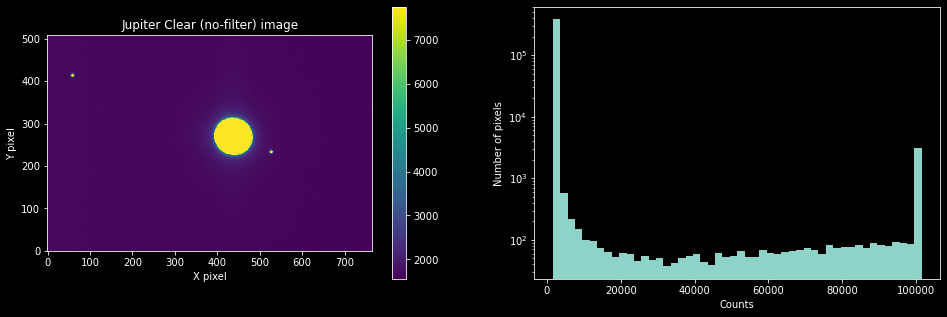

In [18]:
fn_jup = 'Jupiter_Clear_40ms003.FIT'
gain_jup = fits.getheader(fn_jup)['EGAIN']
jupiter_clear = fits.getdata(fn_jup)*gain
pl.figure(figsize=(16,5))
im = pl.subplot(1,2,1).imshow(jupiter_clear, origin='lower', interpolation='none', vmax=5000*gain,)
_=pl.title("Jupiter Clear (no-filter) image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
pl.colorbar(im)

_ = pl.subplot(1,2,2).hist(jupiter_clear.ravel(), bins=50, log=True)
_ = pl.xlabel("Counts")
_ = pl.ylabel("Number of pixels")

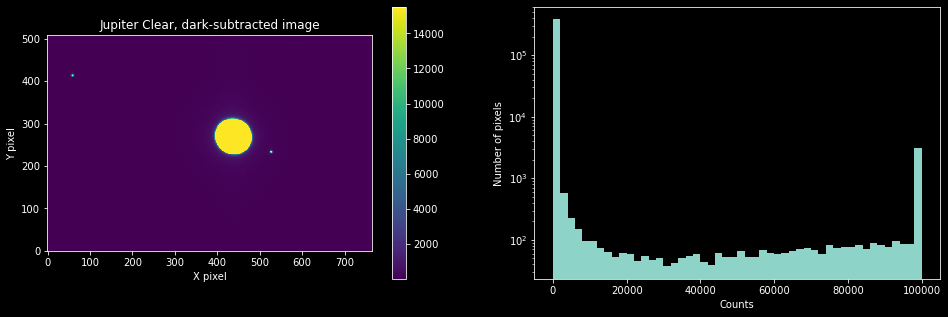

In [19]:
jupiter_clear_darksub = jupiter_clear - average_40ms_dark
jupiter_clear_darksub_uncertainty = (jupiter_clear_darksub + readnoise**2 + uncertainty_on_40ms_mean_dark**2)**0.5
pl.figure(figsize=(16,5))
im = pl.subplot(1,2,1).imshow(jupiter_clear_darksub, origin='lower', interpolation='none', vmax=10000*gain, vmin=10*gain)
_=pl.title("Jupiter Clear, dark-subtracted image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
pl.colorbar(im)

_ = pl.subplot(1,2,2).hist(jupiter_clear_darksub.ravel(), bins=50, log=True)
_ = pl.xlabel("Counts")
_ = pl.ylabel("Number of pixels")

In [20]:
jupiter_clear_darksub_flattened = jupiter_clear_darksub / normalized_mean_clear_flat
jupiter_clear_darksub_flattened_uncertainty = ((jupiter_clear_darksub_uncertainty**2 / jupiter_clear_darksub**2 +normalized_flat_uncertainty**2 / normalized_mean_clear_flat**2) * jupiter_clear_darksub_flattened**2)**0.5

pl.figure(figsize=(16,5))
im = pl.subplot(1,2,1).imshow(jupiter_clear_darksub_flattened, origin='lower', interpolation='none', vmax=600*gain, vmin=400*gain)
pl.colorbar(im)
_=pl.title("Jupiter Clear, dark-subtracted, flattened image")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")

_ = pl.subplot(1,2,2).hist(jupiter_clear_darksub_flattened.ravel(), bins=50, log=True)
_ = pl.xlabel("Counts")
_ = pl.ylabel("Number of pixels")

NameError: name 'normalized_mean_clear_flat' is not defined

In [ ]:
pl.figure(figsize=(16,5))
SNR_jup = jupiter_clear_darksub_flattened / jupiter_clear_darksub_flattened_uncertainty
im = pl.subplot(1,2,1).imshow(SNR_jup, origin='lower', interpolation='none', vmin=10, vmax=50)
_=pl.title("Jupiter SNR")
_=pl.xlabel("X pixel")
_=pl.ylabel("Y pixel")
pl.colorbar(im)

_ = pl.subplot(1,2,2).hist(SNR_jup.ravel(), bins=50, log=True)
_ = pl.xlabel("SNR")
_ = pl.ylabel("Number of pixels")